# Outlier Detection with Autoencoders

Autoencoders are a type of deep-learning architectures that are used to learn how to compress and decompress data faithfully. The compression layers are referred to as the encoding layers, and the decompression layers are referred to as the decoding layers. Conceptually, when we are encoding data, we are squeezing the n-dimensional data vector to successively smaller dimensionsional space representation. If a vector is 256 in length (or has 256 dimensions), we might have successive layers to encode this vector into 128, 64, 36, 18 and 9 dimensions. These smaller dimensional space are said to be `latent` space, or higher-order (although they are lower dimensions) space. The second part of the autoencoder architecture are the decoding layers, which is essentially a reversal of the encoding layers. In the example here, we will have layers that builds the 9-dimensional vector to 18, 36, 64, 128 and 256 dimensions. A lot of the information is lost during encoding, but this information may be looked at as noise or non-essential. Once we are done with encoding, what remains is the essential information to reconstruct the input vector, and the decoding layers attempts to reconstruct the output to be like the input based on the essential information. 

Autoencoders may be useful for a variety of things, including, anomaly or outlier/inlier detection. We may train an autoencoder on inliers and compute the expected error for inliers. When a new observation comes through, we feed this observation into the autoencoder and compute its reconstruction error; if it is different above a threshold from the expected error for inliers, then such observation may be considered an outlier. Let's see how autoencoders may be used to detect outliers and inliers.

## Data

The data is sampled from $X \sim \mathcal{N}(0, 1)$.

In [1]:
import numpy as np
import pandas as pd
import random as rand

np.random.seed(37)
rand.seed(37)

X = np.random.normal(loc=0, scale=1, size=1_000).reshape(-1, 1)

print(f'X shape = {X.shape}')

X shape = (1000, 1)


## Dataset and Data Loader

We will use PyTorch to build an autoencoder, and as such, will construct a dataset and data loader from the sampled data.

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import *

class GaussianDataset(Dataset):
    def __init__(self, X, device, clazz=0):
        self.__device = device
        self.__clazz = clazz
        self.__X = X

    def __len__(self):
        return self.__X.shape[0]

    def __getitem__(self, idx):
        item = self.__X[idx,:]
        
        return item, self.__clazz

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset = GaussianDataset(X=X, device=device)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=1)

cuda


## Autoencoder architecture

Look at the architecture in this autoencoder; it has 5 encoding layers and 5 decoding layers. All activation layers between these layers are ReLU.

In [3]:
from torchvision import datasets
from torchvision import transforms

class AE(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
          
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )
          
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, input_size)
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Learning

We will define our loss function to be mean-squared error (MSE) and use the Adam optimizer.

In [4]:
model = AE(input_size=X.shape[1]).double().to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

In [5]:
epochs = 20
loss_df = []

for epoch in range(epochs):
    losses = []
    
    for (items, _) in data_loader:  
        items = items.to(device)
        optimizer.zero_grad()
        
        reconstructed = model(items)
        loss = loss_function(reconstructed, items)
        
        loss.backward()
        
        optimizer.step()
        
        losses.append(loss.detach().cpu().numpy().item())
    
    losses = np.array(losses)
    
    loss_df.append({
        'epoch': epoch + 1,
        'loss': losses.mean()
    })
    
loss_df = pd.DataFrame(loss_df)
loss_df.index = loss_df['epoch']
loss_df = loss_df.drop(columns=['epoch'])

The average loss over each epoch will differ base on the batch size (set to 64 earlier).

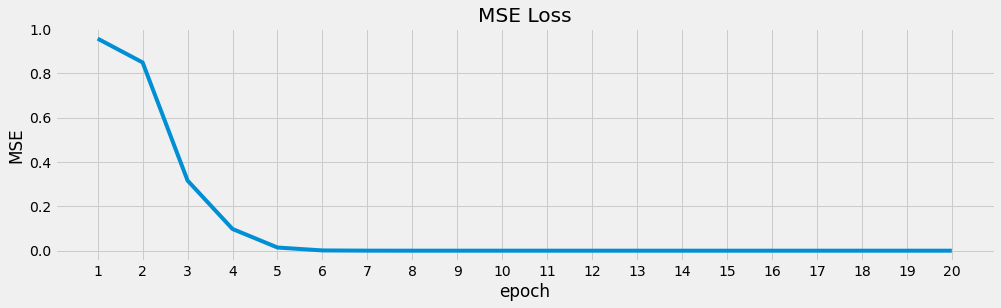

In [6]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

ax = loss_df['loss'].plot(kind='line', figsize=(15, 4), title='MSE Loss', ylabel='MSE')
_ = ax.set_xticks(list(range(1, 21, 1)))

Once we learn the parameters for the autoencoder, we can predict one observation at a time from the dataset.

In [7]:
pd.DataFrame([{'y_true': dataset[r][0][0], 'y_pred': model(torch.from_numpy(dataset[r][0]).to(device)).detach().cpu().item()} 
              for r in range(10)])

,y_true,y_pred
0,-0.054464,-0.053710
1,0.674308,0.671159
2,0.346647,0.346930
3,-1.300346,-1.300607
4,1.518512,1.517112
5,0.989824,0.989446
6,0.277681,0.277272
7,-0.448589,-0.445989
8,0.961966,0.961623
9,-0.827579,-0.827679


Batch prediction from the data loader is also possible.

In [8]:
import itertools

res = ((np.ravel(items.numpy()), np.ravel(model(items.to(device)).detach().cpu().numpy())) 
       for i, (items, _) in enumerate(data_loader) if i < 10)
res = map(lambda tup: [{'y_true': t, 'y_pred': p} for t, p in zip(tup[0], tup[1])], res)
res = itertools.chain(*res)
res = pd.DataFrame(res)
res

,y_true,y_pred
0,0.737685,0.734922
1,1.603115,1.601040
2,-1.010090,-1.010437
3,0.606812,0.606252
4,-0.059037,-0.058368
...,...,...
635,-0.902755,-0.901273
636,-1.248267,-1.249291
637,2.005822,2.002879
638,0.590822,0.590642


## Detecting outliers

Now, let's see if we can detect outliers with the autoencoder. We will sample 4 data sets as follows.

- $A \sim \mathcal{N}(\mu_X, \sigma_X)$
- $B \sim \mathcal{N}(\mu_X + 1, \sigma_X)$
- $C \sim \mathcal{N}(\mu_X + 1, \sigma_X + 2)$
- $D \sim \mathcal{N}(\mu_X + 10, \sigma_X)$

In [9]:
A = np.random.normal(loc=0, scale=1, size=1_000).reshape(-1, 1)
B = np.random.normal(loc=1, scale=1, size=1_000).reshape(-1, 1)
C = np.random.normal(loc=1, scale=2, size=1_000).reshape(-1, 1)
D = np.random.normal(loc=10, scale=1, size=1_000).reshape(-1, 1)

The mean average error from the training data $X$ may be computed and used as a threshold to consider if a new observation is an outlier or inlier. 

In [10]:
def predict(m, y_true, device):
    y_pred = m(torch.from_numpy(y_true).to(device)).detach().cpu().item()
    return {'y_true': y_true[0], 'y_pred': y_pred}

pred_df = pd.DataFrame([predict(model, X[r,:], device) for r in range(X.shape[0])])
mae = np.abs(pred_df.y_true - pred_df.y_pred).mean()
print(f'MAE = {mae:.5f}')

MAE = 0.00136


Detecting outliers from A.

In [11]:
def detect_outlier(m, X, device, mae):
    df = pd.DataFrame([predict(model, X[r,:], device) for r in range(X.shape[0])])
    df['error'] = np.abs(df.y_true - df.y_pred)
    df['outlier'] = df['error'].apply(lambda e: 1 if e > mae else 0)
    return df

detect_outlier(model, A, device, mae).head(n=10)

,y_true,y_pred,error,outlier
0,-0.659954,-0.656442,0.003512,1
1,-0.072388,-0.072277,0.000111,0
2,-0.988276,-0.988780,0.000505,0
3,0.510436,0.510648,0.000212,0
4,0.442500,0.443603,0.001103,0
5,-0.238447,-0.237134,0.001313,0
6,-1.113931,-1.111392,0.002538,1
7,-0.500849,-0.505284,0.004435,1
8,0.486258,0.486939,0.000680,0
9,-0.754691,-0.755790,0.001099,0


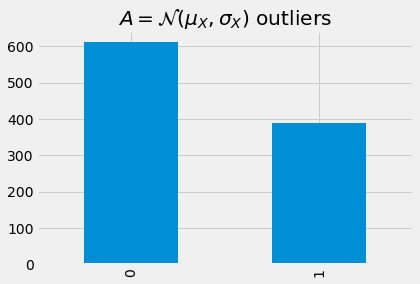

In [12]:
_ = detect_outlier(model, A, device, mae)['outlier']\
    .value_counts()\
    .sort_index()\
    .plot(kind='bar', title=r'$A \sim \mathcal{N}(\mu_X, \sigma_X)$ outliers')

Detecting outliers from B.

In [13]:
detect_outlier(model, B, device, mae).head(n=10)

,y_true,y_pred,error,outlier
0,1.054522,1.052940,0.001582,1
1,-0.118952,-0.120050,0.001099,0
2,0.781712,0.780419,0.001293,0
3,-0.947611,-0.946486,0.001125,0
4,1.566011,1.564284,0.001727,1
5,1.937544,1.934747,0.002797,1
6,-1.634584,-1.633686,0.000898,0
7,1.241298,1.239089,0.002209,1
8,1.521333,1.519925,0.001407,1
9,3.097915,3.086046,0.011870,1


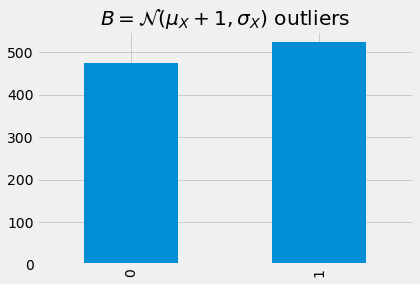

In [14]:
_ = detect_outlier(model, B, device, mae)['outlier']\
    .value_counts()\
    .sort_index()\
    .plot(kind='bar', title=r'$B \sim \mathcal{N}(\mu_X + 1, \sigma_X)$ outliers')

Detecting outliers from C.

In [15]:
detect_outlier(model, C, device, mae).head(n=10)

,y_true,y_pred,error,outlier
0,-1.326775,-1.326583,0.000192,0
1,0.833414,0.832504,0.000909,0
2,-0.872608,-0.871917,0.000692,0
3,3.983235,3.925525,0.057710,1
4,-1.085848,-1.083765,0.002084,1
5,0.385625,0.386337,0.000712,0
6,2.213190,2.209871,0.003319,1
7,0.457719,0.458954,0.001236,0
8,2.334519,2.330911,0.003608,1
9,-0.450000,-0.447540,0.002460,1


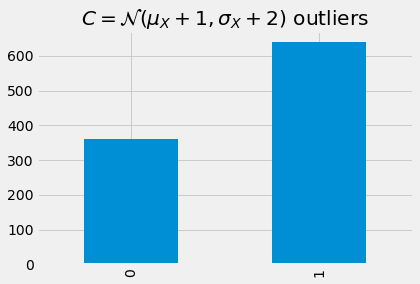

In [16]:
_ = detect_outlier(model, C, device, mae)['outlier']\
    .value_counts()\
    .sort_index()\
    .plot(kind='bar', title=r'$C \sim \mathcal{N}(\mu_X + 1, \sigma_X + 2)$ outliers')

In [17]:
detect_outlier(model, D, device, mae).head(n=10)

,y_true,y_pred,error,outlier
0,11.090525,10.648561,0.441965,1
1,9.474894,9.123159,0.351735,1
2,9.906585,9.530741,0.375844,1
3,10.568700,10.155879,0.412822,1
4,8.904352,8.583365,0.320986,1
5,10.612258,10.197003,0.415254,1
6,7.439080,7.199599,0.239482,1
7,10.321630,9.922607,0.399023,1
8,10.054895,9.670769,0.384127,1
9,9.925478,9.548579,0.376899,1


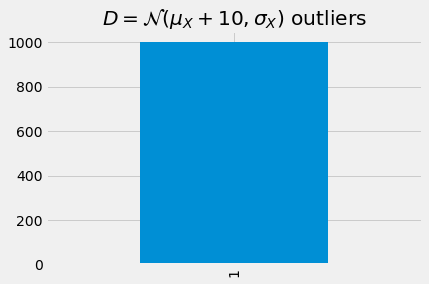

In [18]:
_ = detect_outlier(model, D, device, mae)['outlier']\
    .value_counts()\
    .sort_index()\
    .plot(kind='bar', title=r'$D \sim \mathcal{N}(\mu_X + 10, \sigma_X)$ outliers')